In [1]:
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
from random import shuffle
from PIL import Image

def load_data(pattern):
    return glob.glob(pattern)

def load_image(fn, direction):
    im = Image.open(fn)
    arr = np.array(im)/255*2-1
    imgA = arr[:, imagesize:imagesize*2]
    imgB = arr[:, 0:imagesize]
    if direction == 0:
        return imgA, imgB
    else:
        return imgB, imgA

dataset = 'facades'
imagesize = 256
trainAB = load_data('../data/{}/train/*.jpg'.format(dataset))
valAB = load_data('../data/{}/val/*.jpg'.format(dataset))

In [3]:
def minibatch(dataAB, batchsize, direction):
    length = len(dataAB)
    i = 0
    epoch = 0
    while True:
        if (i + batchsize) > length:
            shuffle(dataAB)
            i = 0
            epoch += 1
        trainA = []
        trainB = []
        for j in range(i, i + batchsize):
            imgA, imgB = load_image(dataAB[j], direction)
            trainA.append(imgA)
            trainB.append(imgB)
        trainA = np.float32(trainA)
        trainB = np.float32(trainB)
        i += batchsize
        yield epoch, trainA, trainB

In [4]:
from IPython.display import display
def showX(X, rows=1):
    int_X = ((X+1)*255/2).clip(0, 255).astype('uint8')
    b, h, w, c = int_X.shape
    int_X = int_X.reshape(rows, -1, h, w, 3).swapaxes(1, 2).reshape(rows*h, -1, 3)
    display(Image.fromarray(int_X))

(6, 256, 256, 3)


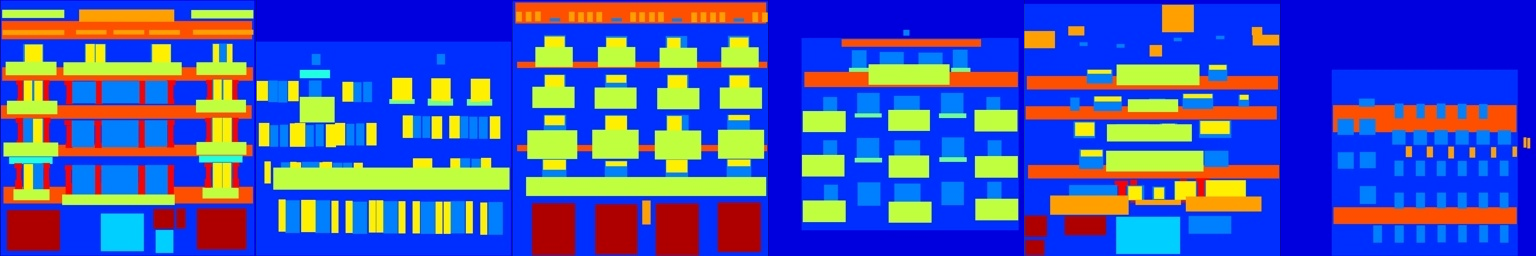

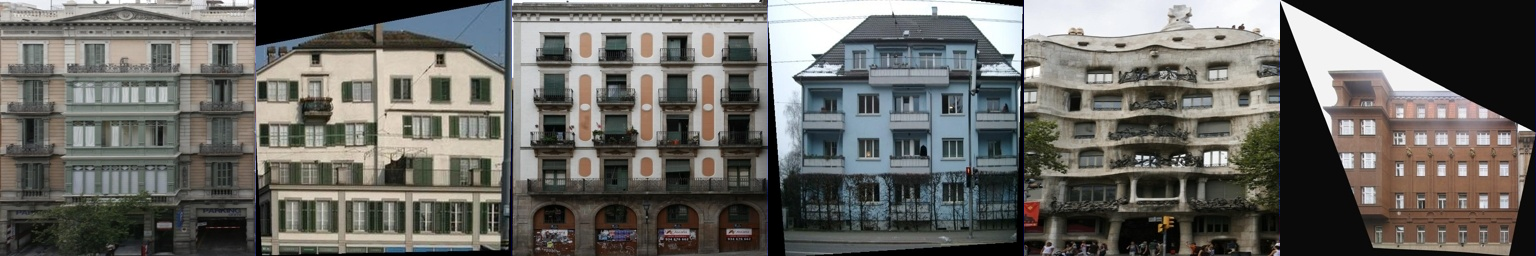

In [5]:
train_batch = minibatch(trainAB, 6, 0)
_, trainA, trainB = next(train_batch)
print(trainA.shape)
showX(trainA)
showX(trainB)
del train_batch, trainA, trainB

In [6]:
imagesize = 256
in_c = 3
out_c = 3

ndf = 64 #number of discriminator first layer channels
ngf = 64

batch_size = 1
direction = 0

In [7]:
conv_init = tf.initializers.random_normal(stddev=0.02)
gamma_init = tf.initializers.random_normal(stddev=0.02, mean=1)

def LeakyRelu(x, leak=0.2):
    return tf.maximum(x, x*leak)

def conv2d(x, f, **k):
    return tf.layers.conv2d(x, f, kernel_initializer=conv_init, **k)

def batchnorm(x):
    return tf.layers.batch_normalization(x, epsilon=1e-5, training=True, fused=True, gamma_initializer=gamma_init, axis=3)

def ZeroPadding2D(x):
    return tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]])

In [8]:
def discriminator(input_a, input_b, max_layers=3,):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        _ = tf.concat([input_a, input_b], axis=-1)
        _ = conv2d(_, ndf, kernel_size=4, strides=2, padding='same', activation=LeakyRelu)

        for layer in range(1, max_layers):
            next_c = ndf * min(2**layer, 8)
            _ = conv2d(_, next_c, kernel_size=4, strides=2, padding='same', use_bias=False)
            _ = batchnorm(_)
            _ = LeakyRelu(_)

        next_c = ndf * min(2**max_layers, 8)
        _ = ZeroPadding2D(_)
        _ = conv2d(_, next_c, kernel_size=4, use_bias=False)
        _ = batchnorm(_)
        _ = LeakyRelu(_)

        _ = ZeroPadding2D(_)
        _ = conv2d(_, 1, kernel_size=4, activation = tf.nn.sigmoid)
        return _

In [9]:
def generator(input_a):
    max_nf = 8 * ngf
    size = imagesize
    next_c = ngf
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(x, nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same")
        if s>2:
            if use_batchnorm:
                x = batchnorm(x)
            x2 = LeakyRelu(x)
            x2 = block(x2, s//2, nf_next)
            x = tf.concat([x, x2], axis=-1)
        x = tf.nn.relu(x)
        x = tf.layers.conv2d_transpose(x, nf_out, kernel_size=4, strides=2, 
                                       use_bias=(not use_batchnorm), padding='same',
                                       kernel_initializer = conv_init)
                        
        if use_batchnorm:
            x = batchnorm(x)
        if s <=8:
            x = tf.layers.dropout(x, rate=0.5, training=True)
        return x
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        _ = block(input_a, size, in_c, False, nf_out=out_c, nf_next=ngf)
        _ = tf.nn.tanh(_)
        return _

In [10]:
input_a = tf.placeholder(dtype=tf.float32, shape=[None, imagesize, imagesize, in_c])
input_b = tf.placeholder(dtype=tf.float32, shape=[None, imagesize, imagesize, out_c])

D_real = discriminator(input_a, input_b)
G_fake = generator(input_a)
D_fake = discriminator(input_a, G_fake)

loss_fn = lambda output, target: -tf.reduce_mean(tf.log(output + 1e-12) * target + tf.log(1 - output + 1e-12) * (1 - target))
D_real_loss = loss_fn(D_real, tf.ones_like(D_real))
D_fake_loss = loss_fn(D_fake, tf.zeros_like(D_fake))
D_loss = D_real_loss + D_fake_loss

L1_loss = tf.reduce_mean(tf.abs(G_fake - input_b))
G_loss_fake = loss_fn(D_fake, tf.ones_like(D_fake))
G_loss = G_loss_fake + 100 * L1_loss

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

D_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(D_loss, var_list=D_vars)
G_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5).minimize(G_loss, var_list=G_vars)
sess.run(tf.global_variables_initializer())

150/60000, D_loss 0.8380842208862305, G_loss 1.1600052118301392, L1_loss 0.09670732170343399, D_real_curr 0.4221094846725464, D_fake_curr 0.41597476601600647


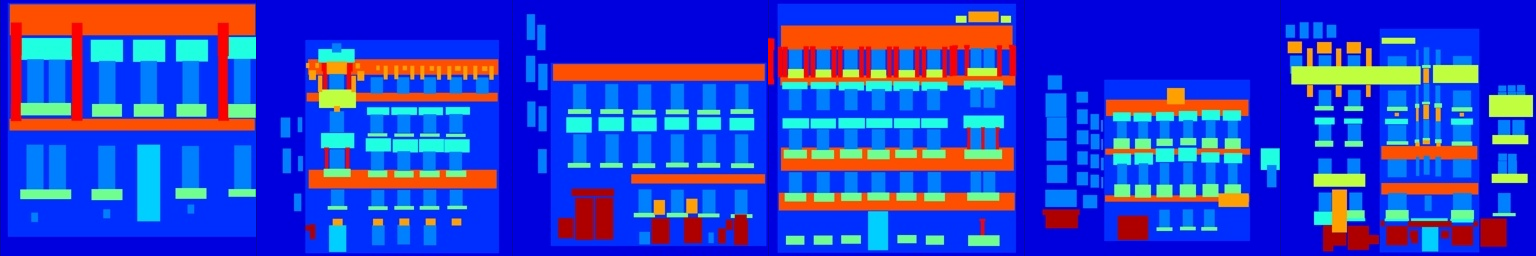

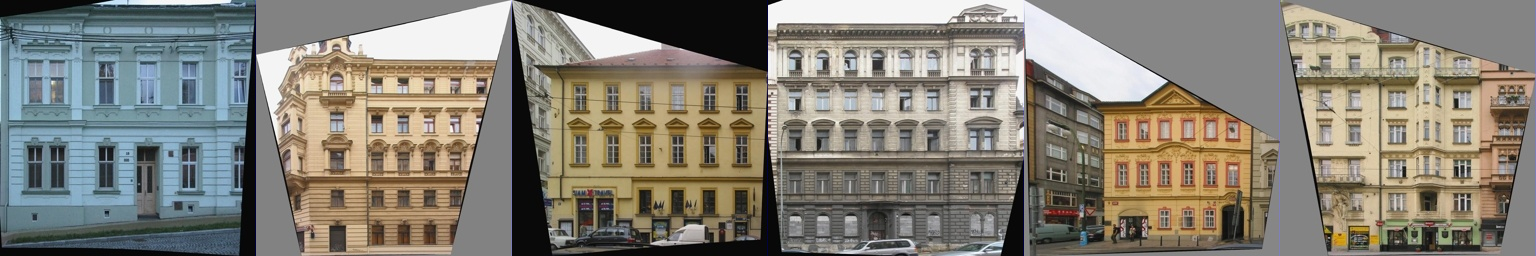

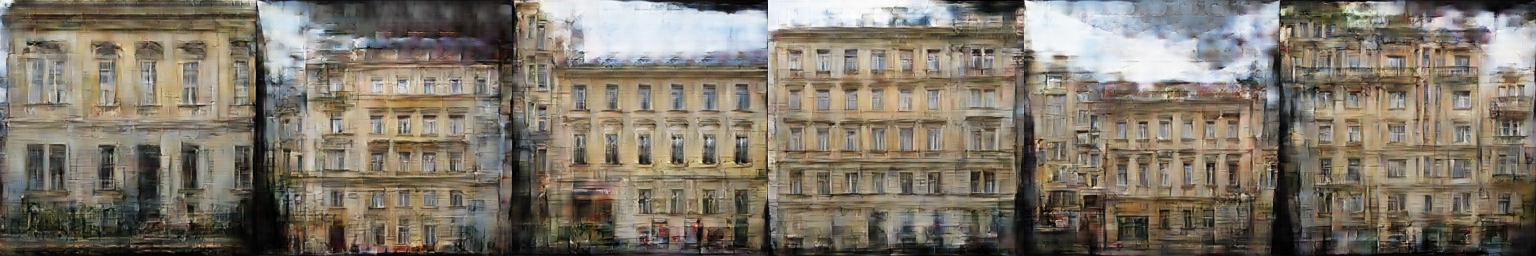

In [11]:
from IPython.display import clear_output
epoch_num = 150
epoch = 0
gen_iter = 0
display_iter = 500
train_batch = minibatch(trainAB, batch_size, direction)
val_batch = minibatch(valAB, 6, direction)
while epoch < epoch_num:
    epoch, trainA, trainB = next(train_batch)
    D_loss_curr, _, D_real_curr, D_fake_curr = sess.run([D_loss, D_optimizer, D_real_loss, D_fake_loss], feed_dict={input_a: trainA, input_b: trainB})
    G_loss_curr, L1_loss_curr, _ = sess.run([G_loss_fake, L1_loss, G_optimizer], feed_dict={input_a: trainA, input_b: trainB})
    if gen_iter % display_iter == 0:
        if gen_iter % (5*display_iter) == 0:
            clear_output()
        print('{}/{}, D_loss {}, G_loss {}, L1_loss {}, D_real_curr {}, D_fake_curr {}'
              .format(epoch, gen_iter, D_loss_curr, G_loss_curr, L1_loss_curr, D_real_curr, D_fake_curr))
        _, valA, valB = next(val_batch)
        fakeB = sess.run([G_fake], feed_dict={input_a: valA})[0]
        showX(valA)
        showX(valB)
        showX(fakeB)
    gen_iter += 1